# Applied Data Science Capstone - Week 4 and 5

## Project name: Dinner'sOut

In this assignment it is required to use the previous skills to come up with a solution to any custom problem.

## Description

The following algorigthm is made to assist someone wanting to go to a restaurant anywhere on the city. It gathers the neighborhood coordinates from Wikipedia and data from restaurants on FourSquare API. Those data are used to categorize the neighborhoods based on cost, distance from your house, quantity and variety of restaurants. Depending on your mood you may want to a place with lots of options, or a expensive comfy place on adjacent locations or a farther place with cheap options. Those categories are labeled each time someone input its address, therefore it is customizable.

The conclusion at the end of the page points to improvements that could be made and the considerations discovered while doing this excercise.

## Available data

- Initial coordinates (city, neighborhood, specific place, etc)
- Venue type (this use case is restricted to "food")
- Venue coordinates (used the neighborhood coordinates instead)
- Distance from venue to initial coordinates (calculated from geopy.distance)
- Cost (FourSquare has an cost attribute but it would require many more queries than the allowed by free users)
- Popularity (same as above)
- Neighborhoods in Rio de Janeiro (from Wikipedia)
- GDP per capta per neighborhood (used as a proxy to estimate the cost of the venues)

### Methodology

We are gathering data from two distinct sources: Wikipedia and FourSquare API (the same as the previous assignments).
Those datas will be merged into a single dataframe wigh aggregated values that will be used as the features of our ML algorithm.

We are using K-means since it is simple and easy, it will provide us with visual results nice to be displayed on the Folium map. But in order to use this approach, I adopted the elbow method for helping me find the best number of clusters and the data is normalized with mean 0 and std dev 1 (assuming it is a bell curve distribution).

The result is analyzed with a simple table with the mean values for each category, enough to describe the expected results (if it happens).

### Package Installation Step

These steps are necessary only once on each machine. Those are the packages used for specific functions for different stages in our code.

In [ ]:
pip install requests

In [ ]:
pip install pandas

In [ ]:
pip install geocoder

In [ ]:
pip install lxml

In [ ]:
pip install html5lib

In [ ]:
pip install BeautifulSoup4

In [ ]:
pip install matplotlib

In [ ]:
pip install sklearn

In [ ]:
pip install geopy

In [ ]:
pip install folium

### Package imports

After the installation it is necessary to import those packages. Some as objects and some as indirect tools inside our functions.
And to facilitate the inspection of our data, the pandas option to show every row in our table is necessary. The side effect is a visual pollution in our document.

In [1]:
import requests
import lxml
import html5lib
import pandas as pd
import numpy as np
import geocoder
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import geopy.distance
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
pd.set_option('display.max_rows', None)

### Get list of neighborhoods

To start, we need specific information on the geographic region we gonna analyze. I am choosing the whole city of Rio de Janeiro. All of the 163 neighborhoods are listed on a Wikipedia page that compares the GDP per capta of each location.
To fetch this data we are using the read_html funcion of Pandas. This function indirectly calls html5lib and lxml.

In [3]:
# Get neighborhood list from wikipedia page
tableUrl = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_IDH'
tableHtml = pd.read_html(io=tableUrl, match='Bairro', index_col = 0)

# Select only the desired columns
rio_data = tableHtml[0].loc[:,['Bairro ou grupo de bairros','Renda per capita (em R$ de 2000)']]

# Change column names
rio_data.columns = ['Neighborhood','GDP per capta']

# Clean the number values on GDP per capta column
rio_data['GDP per capta'] = rio_data['GDP per capta'].str.replace('\[b]','')
rio_data['GDP per capta'] = rio_data['GDP per capta'].str.replace('\[a]','')
rio_data['GDP per capta'] = rio_data['GDP per capta'].str.replace(' ','')

# Separate neighborhoods grouped with comma
rio_data = pd.DataFrame(rio_data['Neighborhood'].str.split(',').tolist(), index=rio_data['GDP per capta']).stack()
rio_data = rio_data.reset_index()[[0, 'GDP per capta']]
rio_data.columns = ['Neighborhood', 'GDP per capta']

<ipython-input-3-0636914196c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_data['GDP per capta'] = rio_data['GDP per capta'].str.replace('\[b]','')
<ipython-input-3-0636914196c0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_data['GDP per capta'] = rio_data['GDP per capta'].str.replace('\[a]','')
<ipython-input-3-0636914196c0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [4]:
len(rio_data['Neighborhood'])

163

### Get coordinates of the city

To center our map correctly, we are using the geolocator to get the general coordinates of the city.

In [5]:
address_city = 'Rio de Janeiro, BR'

geolocator = Nominatim(user_agent="rj_explorer")
location = geolocator.geocode(address_city)
lat_city = location.latitude
long_city = location.longitude

### Include coordinates for all neighborhoods

To represent each neighborhood on the map and calculate the distances we are using the same code of geolocator on each line of our table.

In [6]:
latitude = []
longitude = []

for address in rio_data['Neighborhood']:
    geolocator = Nominatim(user_agent="rj_explorer")
    location = geolocator.geocode(address + ", Rio de Janeiro")
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    #print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))
    
coordinates = pd.DataFrame([latitude,longitude])
rio_data = pd.concat([rio_data,coordinates.T], axis=1)
rio_data.columns = ['Neighborhood', 'GDP per capta', 'Latitude', 'Longitude']
rio_data

,Neighborhood,GDP per capta,Latitude,Longitude
0,Gávea,"2139,56",-22.981424,-43.238324
1,Leblon,"2441,28",-22.983556,-43.224938
2,Jardim Guanabara,"1316,86",-22.812836,-43.200779
3,Ipanema,"2465,45",-22.983956,-43.202216
4,Lagoa,"2955,29",-22.962466,-43.202488
5,Flamengo,"1781,71",-22.933984,-43.174574
6,Humaitá,"1830,65",-22.954641,-43.200480
7,Barra da Tijuca,"2488,47",-22.999740,-43.365993
8,Joá,"2488,47",-23.007780,-43.287234
9,Laranjeiras,"1679,22",-22.934317,-43.187816


### Plot neighborhoods on map

With the coordinates, we can use the folium package to display a map and all the points of interest.

In [7]:
map_rio = folium.Map(location=[lat_city, long_city], zoom_start=10)

for lat, lng, neighborhood in zip(rio_data['Latitude'], rio_data['Longitude'], rio_data['Neighborhood']):
    label = '{}, Rio de Janeiro'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rio)  
    
map_rio

### Set Foursquare credentials

This are the necessary data to trade information with the FourSquare API.

In [8]:
CLIENT_ID = 'DZ5QCXOQRO1EQVCKNK2QSH4E0YNX2VF02AR1LMWBRXV2LO1C'
CLIENT_SECRET = 'SMQLPX1OEWHJDKV20ABVCXKP1V3LTT144UCN51SD2SGQLEKT'
VERSION = '20180605'
LIMIT = 100

### Setup query function for Foursquare API

The credentials are used to define the call function, same as our previous excersise on Week 3 of the course. This function get all the venue's name, location and category. We are interested only on category.

In [9]:
section = 'food'
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            section,
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get values from API

Now we call the funcion for each time on our talbe, getting the respective venues for each neighborhood.

In [10]:
rio_venues = getNearbyVenues(names=rio_data['Neighborhood'],
                                   latitudes=rio_data['Latitude'],
                                   longitudes=rio_data['Longitude']
                                  )

Gávea
Leblon
Jardim Guanabara
Ipanema
Lagoa
Flamengo
Humaitá
Barra da Tijuca
 Joá
Laranjeiras
Jardim Botânico
Copacabana
Leme
Botafogo
 Urca
Maracanã
Glória
Méier
Tijuca
 Alto da Boa Vista
Todos os Santos
Anil
Vila da Penha
Andaraí
Riachuelo
Campinho
 Vila Valqueire
Moneró
 Portuguesa
Catete
Vila Isabel
Cachambi
Pechincha
Freguesia
Recreio dos Bandeirantes
 Grumari
Centro
 Lapa
Higienópolis
Santa Teresa
 Cosme Velho
Água Santa
 Encantado
Taquara
Vila Kosmos
Vidigal
 São Conrado
Cidade Nova
 Praça da Bandeira
Bonsucesso
Cocotá
 Bancários
Maria da Graça
 Del Castilho
Ribeira
 Cacuia
Lins de Vasconcelos
Engenho Novo
Zumbi
 Pitangueiras
 Praia da Bandeira
Ramos
Engenho de Dentro
Abolição
Deodoro
 Vila Militar
 Campo dos Afonsos
Jardim Sulacap
Oswaldo Cruz
Olaria
Bento Ribeiro
Piedade
Quintino Bocaiúva
Rio Comprido
Praça Seca
Rio de Janeiro
Jardim América
Jacaré
 Rocha
 Sampaio
Freguesia
Jardim Carioca
Engenho da Rainha
Brás de Pina
São Cristóvão
 Vasco da Gama
Cascadura
Parque Anchieta
Mad

In [ ]:
rio_venues

### Group by variety and quantity of places on each neighborhood

With the results we can calculate the quantity of venues for each location and the variety. The variety is simply the count of unique values on the category column. We have to calculate those on separate lists and transform it to concatenate to our original table.

In [11]:
variety = rio_venues.groupby('Neighborhood', as_index=True)['Venue Category'].nunique()
variety = pd.DataFrame(variety)

In [12]:
quantity = rio_venues.groupby('Neighborhood', as_index=True)['Venue Category'].count()
quantity = pd.DataFrame(quantity)

In [13]:
rio_data_2 = rio_data.set_index('Neighborhood')

In [14]:
df1 = rio_data_2.set_index(rio_data_2.groupby(level=0).cumcount(), append=True)
df2 = variety.set_index(variety.groupby(level=0).cumcount(), append=True)
df3 = quantity.set_index(quantity.groupby(level=0).cumcount(), append=True)

rio_data_2 = pd.concat([df1,df2,df3], axis=1).reset_index(drop=True, level=1)

In [15]:
rio_data_2.columns = ['GDP per capta','Latitude','Longitude','Variety','Quantity']
rio_data_2 = rio_data_2.reset_index()

In [ ]:
rio_data_2

### Get input coordinates

This is the input stage of the code. We need to choose a starting address to for it to calculate the distances of each neighborhood before categorizing the table. I am using my own location here.

In [16]:
address_input = 'Praia de Botafogo, 198, Rio de Janeiro, BR' #my address

geolocator = Nominatim(user_agent="rj_explorer")
location = geolocator.geocode(address_input)
lat_input = location.latitude
long_input = location.longitude

### Calculate the distances from input and neighborhoods

Now we calculate these distances. Since they are all in latitude and longitude coordinates I am using the geopy package to return the distances in kilometers.

In [17]:
distance = []

for lat, long in zip(rio_data_2['Latitude'],rio_data_2['Longitude']):
    coords_1 = (lat_input,long_input)
    coords_2 = (lat,long)
    distance.append(geopy.distance.distance(coords_1, coords_2).km)

### Include distances on main table

Concatenate the calculated distances in our original table.

In [18]:
rio_data_3 = pd.concat([rio_data_2,pd.DataFrame(distance)], axis = 1)
rio_data_3.columns = ['Neighborhood','GDP per capta','Latitude','Longitude','Variety','Quantity','Distance']

In [ ]:
rio_data_3

### Adjust column with string to a number

Our column of GDP per Capta came with a string type. It is using "," as a decimal separator, but we need to conform it to manipulate these numbers, therefore I am subistituting the separator and converting all this column to float.

In [19]:
conv = rio_data_3['GDP per capta'].str.replace(',','.')
rio_data_3['GDP per capta'] = pd.to_numeric(conv, downcast='float')

### Dish the columns not used on decision algorithm

For using our table as a input on the machine learning code, we will get rid of the non numeric columns.

In [20]:
num_data_raw = rio_data_3[['GDP per capta','Variety','Quantity','Distance']]

### Adjust the NaN values

Also for the calculations to work we need to substitute the NaN values to 0. With 0, the values will not interfere with results, as we want it.

In [21]:
num_data_raw = num_data_raw.fillna(0)

### Normalize the values

To give the same weight on all columns we need to normalize the values. The normalization method is the .scale default function witch gives the 0 mean and 1 standard deviation.

In [22]:
num_data_norm = preprocessing.scale(num_data_raw)

### Decide how many groups to form with our algorithm (elbow method)

Since we don't know how many categories we need on our result, we are using the elbow method to help us analyze a good value for our ML object.

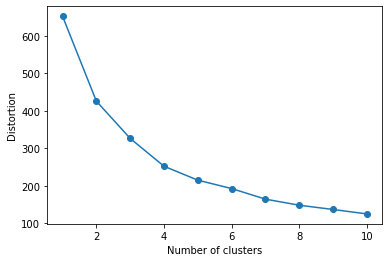

In [23]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=100,
        tol=1e-04, random_state=0
    )
    km.fit(num_data_norm)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Use K-Means to decide which groups of neighborhoods to form

From the plot above we can get confortable with 4 groups in total. Now we can setup the Kmeans algorithm and input our numeric table on int.

In [24]:
ideal_clusters = 4
k_means = KMeans(init="k-means++", n_clusters=ideal_clusters, n_init=10, max_iter=100)

In [25]:
k_means.fit(num_data_norm)

KMeans(max_iter=100, n_clusters=4)

In [26]:
rio_data_3.insert(0, 'Cluster Labels', k_means.labels_)

### Plot groups on map

The map can be updated with the categories to better visualize our result.

In [27]:
# create map
map_rio = folium.Map(location=[lat_city, long_city], zoom_start=10)

# set color scheme for the clusters
x = np.arange(ideal_clusters)
ys = [i + x + (i*x)**2 for i in range(ideal_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rio_data_3['Latitude'], rio_data_3['Longitude'], rio_data_3['Neighborhood'], rio_data_3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_rio)
       
map_rio

### Show groups characteristics

Now we can analyze our original table with the defined cluster to get a better sense of the results. To analyze on a global scale we call a second table with the mean values.

In [28]:
rio_data_3

,Cluster Labels,Neighborhood,GDP per capta,Latitude,Longitude,Variety,Quantity,Distance
0,3,Alto da Boa Vista,120461.000000,-22.962113,-43.253582,NaN,NaN,8.044569
1,3,Bancários,51828.000000,-22.791759,-43.180966,16.0,20.0,16.627687
2,0,Barra de Guaratiba,23437.000000,-23.036004,-43.552140,NaN,NaN,39.727380
3,2,Cacuia,52720.000000,-22.821703,-43.183792,1.0,1.0,13.321468
4,2,Campo dos Afonsos,46213.000000,-22.879519,-43.380364,2.0,2.0,21.855308
5,2,Cidade Universitária,30031.000000,-22.855823,-43.230958,7.0,10.0,10.958317
6,3,Cosme Velho,70119.000000,-22.941514,-43.200624,9.0,10.0,2.295724
7,1,Del Castilho,50540.000000,-22.879562,-43.272420,24.0,68.0,11.873443
8,2,Encantado,49666.000000,-22.897474,-43.304246,3.0,6.0,13.829641
9,2,Engenheiro Leal,32864.000000,-22.874392,-43.325531,3.0,3.0,16.857913


In [29]:
rio_data_3.groupby('Cluster Labels').mean()[['GDP per capta','Variety','Quantity','Distance']]

,GDP per capta,Variety,Quantity,Distance
Cluster Labels,,,,
0,25630.857422,4.250000,6.416667,46.609236
1,34326.730469,23.769231,65.153846,7.843630
2,34367.859375,5.697917,8.156250,15.672471
3,84816.804688,11.235294,19.147059,11.694955


### Results

The result for my specific address returns some of the expected categories that could be used as a option for where to go when choosing a place to eat.

The interpretation of the resulting groups are:
- label a: Medium distance places with plenty of options of restaurants but very expensives. The exotic options.
- label b: Medium distance places with few options but affordable places. The usual.
- label c: Close distance places with lot of options and affordable. The hot spots.
- label d: Farthest places but with very low budget options. The economic options.

*the labels change order and color depending on the order we run the code, therefore I'm using generic names (a,b,c,d) instead of the actual label number and colors.


### Discussion

Those labels can change depending on the input address (the columns Distance would change). But as an improvement the GDP of the neighborhood could be avaluated to better weight the estimated budget of the user and the cost of the place. Also, the real cost could be used instead of the GDP if we were to use this attribute on the paid version of the API.

And for the user experience, the input address could be presented on a dialog box. The output could still use the colored dot map but the values could be decoded on ranges instead of mean values (low cost, medium cost, close distance, distant place, etc).